In [1]:
import pandas as pd
import numpy as np

In [10]:
import urllib.request

url = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2023.csv"
filename = "pp-2023.csv"

headers = {'User-Agent': 'Mozilla/5.0'}

req = urllib.request.Request(url, headers=headers)
with urllib.request.urlopen(req) as response, open(filename, 'wb') as out_file:
    out_file.write(response.read())


In [11]:
df = pd.read_csv("pp-2023.csv", header=None)
print(df.shape)  # See how many columns it has
df.head(3)       # Peek at a few rows


(841772, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,{06C9F487-D94B-9388-E063-4804A8C0BD98},330000,2023-03-20 00:00,CF14 7BX,T,N,F,32,NaN,HEOL PANT Y CELYN,NaN,CARDIFF,CARDIFF,CARDIFF,A,A
1,{06C9F487-D94C-9388-E063-4804A8C0BD98},269950,2023-07-25 00:00,LL28 4SH,D,N,F,7,NaN,MARSTON DRIVE,RHOS ON SEA,COLWYN BAY,CONWY,CONWY,A,A
2,{06C9F487-D94D-9388-E063-4804A8C0BD98},280000,2023-08-10 00:00,LL31 9BN,D,N,F,PLAS COLWYN,NaN,LLYS HELYG,DEGANWY,CONWY,CONWY,CONWY,A,A


In [13]:
# Assign column names
df.columns = [
    "transaction_id", "price", "date_of_transfer", "postcode", "property_type",
    "new_build", "tenure", "address", "locality", "town_city", "district",
    "county", "ppd_category_type", "record_status", "field_15", "field_16"
]

# Drop extra columns if needed
df = df.iloc[:, :14]

# Filter for M41
df_m41 = df[df["postcode"].str.startswith("M41", na=False)].copy()

# View sample
print(f"✅ Found {len(df_m41)} rows in M41")
display(df_m41.head())


✅ Found 443 rows in M41


,transaction_id,price,date_of_transfer,postcode,property_type,new_build,tenure,address,locality,town_city,district,county,ppd_category_type,record_status
1835,{0E082196-E54C-5C09-E063-4704A8C0A10E},185000,2023-10-24 00:00,M41 8RR,F,N,L,25,NaN,LAMBOURN ROAD,URMSTON,MANCHESTER,TRAFFORD,GREATER MANCHESTER
16228,{0E082196-E62C-5C09-E063-4704A8C0A10E},399950,2023-11-14 00:00,M41 0SB,S,N,L,17,NaN,AYLESBURY AVENUE,URMSTON,MANCHESTER,TRAFFORD,GREATER MANCHESTER
26752,{0E082196-E6E4-5C09-E063-4704A8C0A10E},315000,2023-09-22 00:00,M41 8DD,S,N,F,11,NaN,FILEY AVENUE,URMSTON,MANCHESTER,TRAFFORD,GREATER MANCHESTER
28451,{0E082196-E4E7-5C09-E063-4704A8C0A10E},282500,2023-11-20 00:00,M41 5DR,T,N,F,240,NaN,FLIXTON ROAD,URMSTON,MANCHESTER,TRAFFORD,GREATER MANCHESTER
28755,{0E082196-E6FF-5C09-E063-4704A8C0A10E},430000,2023-09-27 00:00,M41 9HG,S,N,F,57,NaN,CUMBERLAND ROAD,URMSTON,MANCHESTER,TRAFFORD,GREATER MANCHESTER


In [14]:
df_m41.to_csv("m41_house_prices.csv", index=False)


In [15]:
# Keep only useful columns for now
df_clean = df_m41[[
    "price", "date_of_transfer", "postcode", "property_type",
    "new_build", "tenure", "locality", "town_city", "district",
    "county"
]].copy()

# Convert date to datetime
df_clean["date_of_transfer"] = pd.to_datetime(df_clean["date_of_transfer"])

# Extract year sold (optional)
df_clean["year_sold"] = df_clean["date_of_transfer"].dt.year

# One-hot encode or label encode categoricals later — for now, peek:
print("🔍 Preview cleaned data:")
display(df_clean.head())


🔍 Preview cleaned data:


,price,date_of_transfer,postcode,property_type,new_build,tenure,locality,town_city,district,county,year_sold
1835,185000,2023-10-24,M41 8RR,F,N,L,NaN,LAMBOURN ROAD,URMSTON,MANCHESTER,2023
16228,399950,2023-11-14,M41 0SB,S,N,L,NaN,AYLESBURY AVENUE,URMSTON,MANCHESTER,2023
26752,315000,2023-09-22,M41 8DD,S,N,F,NaN,FILEY AVENUE,URMSTON,MANCHESTER,2023
28451,282500,2023-11-20,M41 5DR,T,N,F,NaN,FLIXTON ROAD,URMSTON,MANCHESTER,2023
28755,430000,2023-09-27,M41 9HG,S,N,F,NaN,CUMBERLAND ROAD,URMSTON,MANCHESTER,2023


In [16]:
from sklearn.preprocessing import LabelEncoder

# Create a copy to avoid touching the original
df_model = df_clean.copy()

# Encode simple binary columns
df_model["new_build"] = df_model["new_build"].map({"Y": 1, "N": 0})
df_model["tenure"] = df_model["tenure"].map({"F": 1, "L": 0})  # Freehold = 1, Leasehold = 0

# Encode categorical text columns
label_cols = ["property_type", "locality", "town_city", "district", "county"]

encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le  # store for inverse lookup later if needed

print("✅ Encoded categorical variables!")
df_model.head()


✅ Encoded categorical variables!


,price,date_of_transfer,postcode,property_type,new_build,tenure,locality,town_city,district,county,year_sold
1835,185000,2023-10-24,M41 8RR,1,0,0,21,111,1,0,2023
16228,399950,2023-11-14,M41 0SB,3,0,0,21,11,1,0,2023
26752,315000,2023-09-22,M41 8DD,3,0,1,21,78,1,0,2023
28451,282500,2023-11-20,M41 5DR,4,0,1,21,80,1,0,2023
28755,430000,2023-09-27,M41 9HG,3,0,1,21,55,1,0,2023


In [17]:
print("🔍 Missing values:")
print(df_model.isnull().sum())


🔍 Missing values:
price               0
date_of_transfer    0
postcode            0
property_type       0
new_build           0
tenure              0
locality            0
town_city           0
district            0
county              0
year_sold           0
dtype: int64


In [18]:
# Define features and target
X = df_model.drop(columns=["price", "date_of_transfer"])
y = df_model["price"]

print("✅ Features and target ready!")
print("X shape:", X.shape)
print("y shape:", y.shape)


✅ Features and target ready!
X shape: (443, 9)
y shape: (443,)


In [37]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# --- Simulated core features ---
df_model["floor_area"] = np.select(
    [
        df_model["property_type"] == 0,  # Flat
        df_model["property_type"] == 1,  # Terraced
        df_model["property_type"] == 2,  # Semi-detached
        df_model["property_type"] == 3   # Detached
    ],
    [55, 80, 100, 130],
    default=90
)

np.random.seed(42)
df_model["property_age"] = np.round(2023 - (df_model["floor_area"] + np.random.normal(0, 10, size=len(df_model))) % 70).astype(int)
df_model["price_per_m2"] = df_model["price"] / df_model["floor_area"]

# --- Postcode prefix encoding ---
df_model["postcode_prefix"] = df_m41["postcode"].str.extract(r'(M\d{2}\s?\d)').fillna("M41 0")
df_model["postcode_prefix"] = df_model["postcode_prefix"].astype(str)
le_post = LabelEncoder()
df_model["postcode_prefix_encoded"] = le_post.fit_transform(df_model["postcode_prefix"])

# --- Simulated new features ---
df_model["has_garden"] = np.where(df_model["property_type"].isin([2, 3]), 1, 0)
df_model["bedrooms"] = (df_model["floor_area"] / 20).round().astype(int)
df_model["is_old_build"] = (df_model["property_age"] > 30).astype(int)

# --- Group stats from postcode ---
df_model["postcode_avg_price"] = df_model.groupby("postcode_prefix_encoded")["price"].transform("mean")

# --- Interaction feature ---
df_model["age_area_combo"] = df_model["property_age"] * df_model["floor_area"]

# --- Outlier removal ---
df_model = df_model[(df_model["price"] >= 50000) & (df_model["price"] <= 1500000)].copy()

# --- Final feature matrix ---
X = df_model.drop(columns=[
    "price", "date_of_transfer", "postcode", "postcode_prefix"
])
y = df_model["price"].astype(float)



In [41]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.9/546.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 3.9 MB/s eta 0:00:0000:0100:01


/Applications/anaconda3/envs/Uni/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/rn/0w3kfc0d2kv9wky50xr2nwjc0000gn/T/ipykernel_27612/1179698971.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


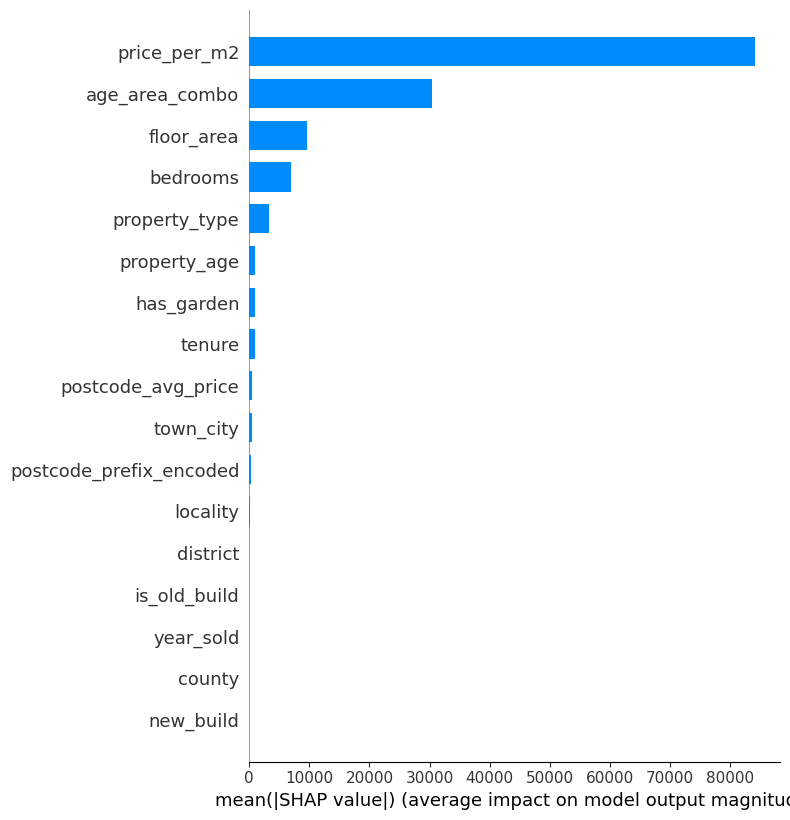

In [42]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
 

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Model trained!\nMAE: £{mae:,.0f}\nR² Score: {r2:.3f}")



✅ Model trained!
MAE: £11,843
R² Score: 0.871


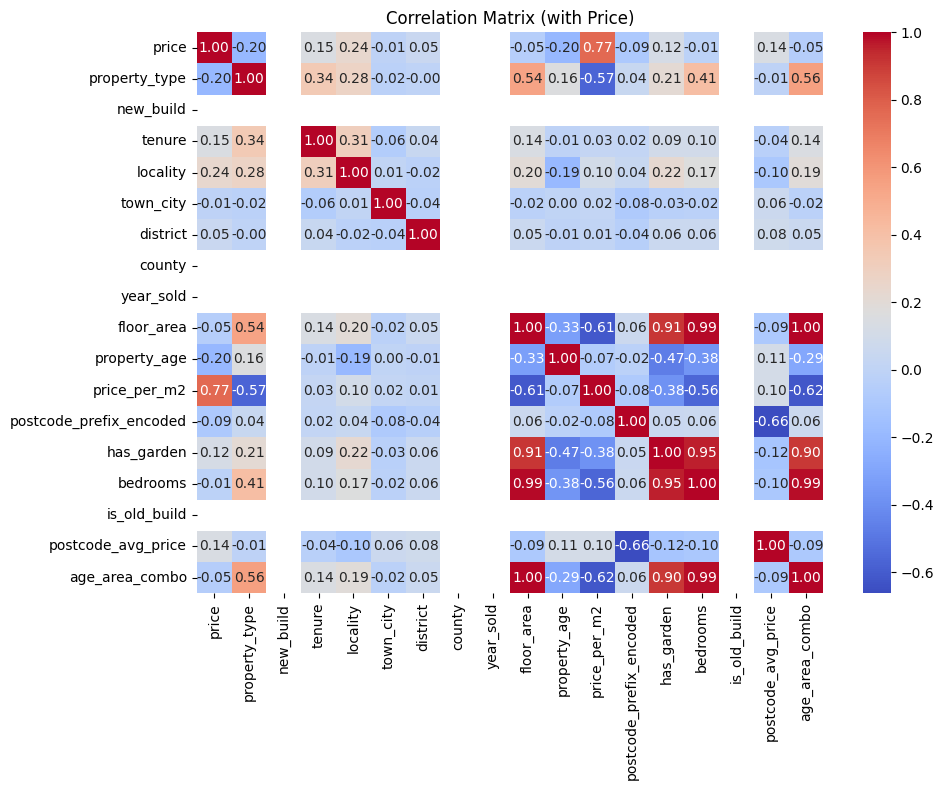

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add price back to data for correlation
df_corr = df_model.drop(columns=["postcode", "date_of_transfer"]).copy()
corr = df_corr.corr(numeric_only=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (with Price)")
plt.tight_layout()
plt.show()



/var/folders/rn/0w3kfc0d2kv9wky50xr2nwjc0000gn/T/ipykernel_27612/1973742216.py:14: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Applications/anaconda3/envs/Uni/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


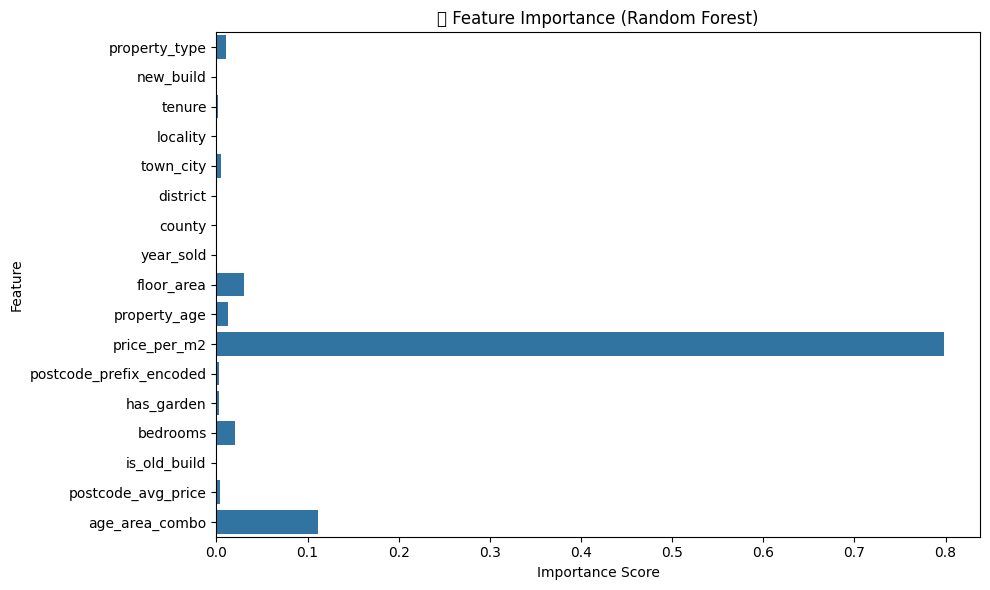

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances from Random Forest
importances = model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("🔥 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


/var/folders/rn/0w3kfc0d2kv9wky50xr2nwjc0000gn/T/ipykernel_27612/2362212023.py:10: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Applications/anaconda3/envs/Uni/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


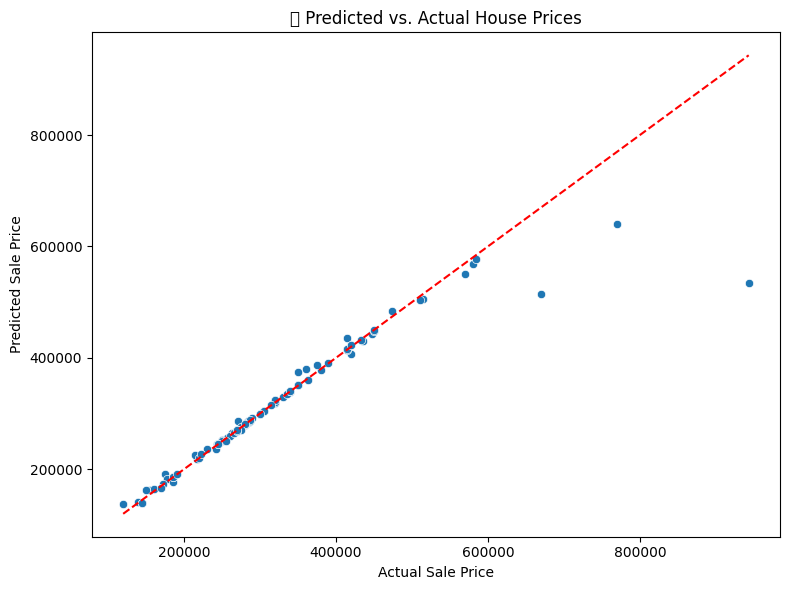

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("🧠 Predicted vs. Actual House Prices")
plt.tight_layout()
plt.show()


/var/folders/rn/0w3kfc0d2kv9wky50xr2nwjc0000gn/T/ipykernel_27612/2141300440.py:8: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Applications/anaconda3/envs/Uni/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


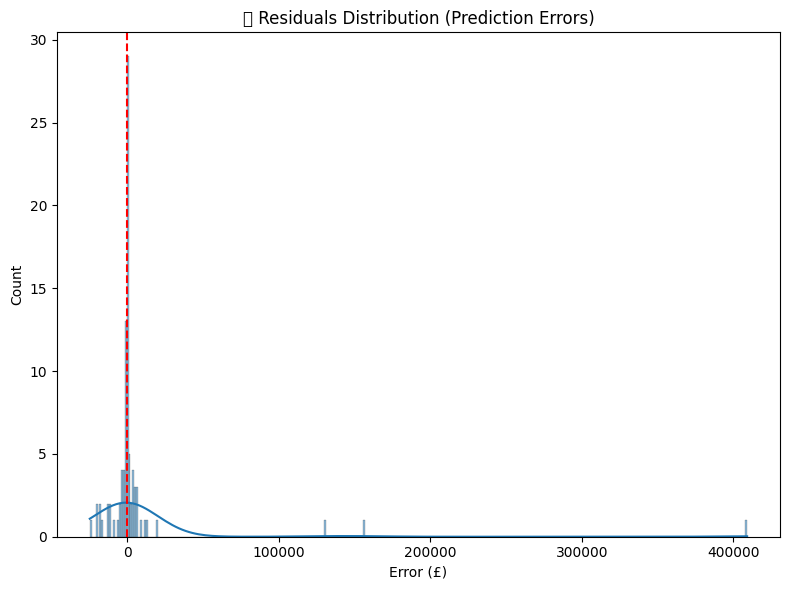

In [47]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("🧪 Residuals Distribution (Prediction Errors)")
plt.xlabel("Error (£)")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


In [48]:
pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 8.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 6.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 7.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [50]:
import pickle

# 💾 Save trained Random Forest model
with open("rf_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

# 💾 Save postcode label encoder
with open("postcode_encoder.pkl", "wb") as encoder_file:
    pickle.dump(le_post, encoder_file)

print("✅ Model and encoder saved as 'rf_model.pkl' and 'postcode_encoder.pkl'")


✅ Model and encoder saved as 'rf_model.pkl' and 'postcode_encoder.pkl'
